## Домашнее здание №2 / Link Prediction

### Ческидова Евгения / 397

----
План выполнения домашнего задания:

1. Краткий обзор исходных данных
2. Генерация дополнительных данных
3. Создание матрицы признаков для ребер
4. Настройка модели и валидация качества модели
5. Отправка результатов в контест на Kaggle

----

В данном домашнем задании вам предстоит построить классификатор, который бы предсказывал наличие или отсутствия ребра в графе между двумя вершинами. Никакой дополнительной информации о вершинах, кроме ее соседей нет, поэтому вам придется создавать вектор признаков для каждой пары вершин на основе топологии графа.

Вершины графа - товары интернет магазина, наличие ребра символизируют о высокой частоте совместной покупки данных товаров вместе. Например если в нашем графе присутствую вершины молоко и хлеб и данные товары часто покупаются вместе, то между данными вершинами будет ребро. Если в нашем графе есть вершины молоко и кроссовки, то между данными вершинами ребра не будет. 

В данном датасете уровень относительной частоты по которому решается есть ребро между вершинами или его нет был определен за нас. Сам датасет был получен краулингом сайта Amazon.com в марте 2003 года, парсилась секция "Люди которые купили данный продукт, также преобретали это..."

Мотивация данного задания: Расширить список блока рекомендаций, за счет товаров которые с высокой вероятность могут оказаться в одной корзине покупателя.

----
Для создания модели и работы с данными мы будем использовать пакет GraphLab, структуры данных SFrame и SGraph идеально подходят для работы с графами. Распределенное хранение данных и применения функций для расчета метрик отдельных вершин сильно облегчают работу с графом.

Библиотека платная, но лицензия для академических целей получается в течении 5 минут, чтобы установить пакет следуйте шагам на сайте - https://turi.com/download/academic.html

----

Описание файлов:

1. the_graph.csv - файл содержащий ребра графа, две колонки: src,dst 
2. suspicions.csv - файл с ребрами, графа. Для данных ребер неизвестно присутствует ли оно в графе или нет.

Описание целевой метрики - в качестве целевой метрики будем использовать ROC AUC http://mlwiki.org/index.php/ROC_Analysis

----

In [1]:
import graphlab as gl
import numpy as np
import pandas as pd

gl.canvas.set_target('ipynb')

In [3]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

### 1. Краткий обзор исходных данных - 10 Баллов

Загрузим данные, найдем ряд базовых статистик:

1. Количество вершин и ребер
2. Распределение степеней вершин графа (График log - log)
3. Плотность графа
4. Диаметр графа
5. Количество треугольников в графе
6. Краткие выводы о данных.
7. БОНУСЫ - сделайте красивую визулизацию или расчет дополнительных метрик с выводами и вы получите дополнительные баллы за задание

In [92]:
edges = gl.SFrame.read_csv('the_graph.csv', delimiter=',', verbose=False)

In [93]:
g = gl.SGraph().add_edges(edges, src_field='src', dst_field='dst')

1. Количество вершин и ребер

In [6]:
vert_edgs = g.summary()

print 'Number of vertices = {0}'.format(vert_edgs['num_vertices'])
print 'Number of edges = {0}'.format(vert_edgs['num_edges'])

Number of vertices = 262111
Number of edges = 1384871


Выполните пункты 2 - 6. В пункте 6 напишите краткие выводы.

### #2 Распределение степеней вершин

In [97]:
from graphlab import degree_counting
deg = degree_counting.create(g)
deg_graph = deg['graph'] # a new SGraph with degree data attached to each vertex
in_degree = deg_graph.vertices[['__id', 'in_degree']]
out_degree = deg_graph.vertices[['__id', 'out_degree']]

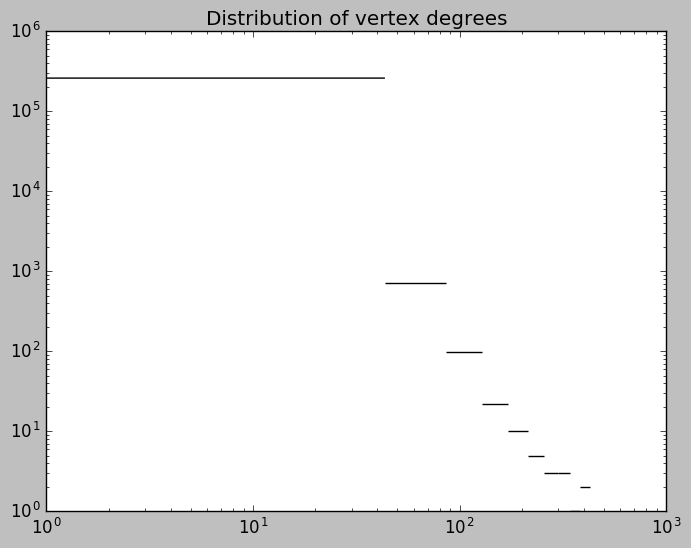

In [103]:
#2. degrees distribution
with plt.style.context(('classic')):
    total_degrees = np.array(in_degree['in_degree']+out_degree['out_degree'])
    plt.hist(total_degrees)
    plt.loglog()
    plt.title("Distribution of vertex degrees")
    plt.show()

У большинства вершин мало связей: до 100.

### #3 Плотность графа
Для ориентированного графа $$\Delta = \frac{L}{g(g-1)}$$
* L -- количество связей в графе
* g -- количество вершин

In [519]:
L = vert_edgs['num_vertices']
g_ = vert_edgs['num_edges']
delta = L*1./((g_-1)*g_)
print delta

1.36668025168e-07


### #4 Диаметр графа
Диаметр графа $\mathrm {diam} (G)$  — это максимум расстояния между вершинами для всех пар вершин.

Расстояние между вершинами — наименьшее число рёбер пути, соединяющего две вершины.

Но посчитать такую штуку сложно вычислительно, поэтому я не буду.

### #5 Количество треугольников в графе
Обнаружилось, что их 717754


In [141]:
from graphlab import triangle_counting
tc = triangle_counting.create(g)
tc_out = tc['triangle_count']
tc_out

Initializing vertex ids.

Removing duplicate (bidirectional) edges.

Counting triangles...

Finished in 3.13389 secs.

Total triangles in the graph : 717754

__id,triangle_count
5,79
7,38
8,166
10,34
27,25
29,48
33,242
47,9
50,6
52,31


[]

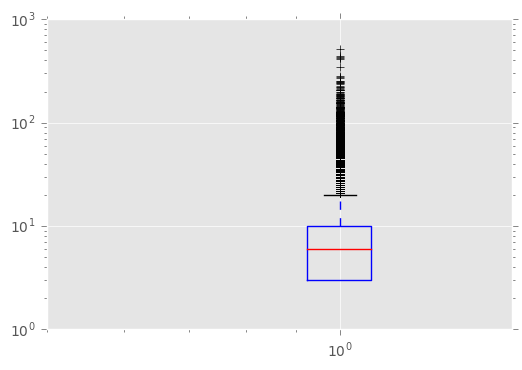

In [154]:
plt.boxplot(tc_out['triangle_count'])
plt.loglog()

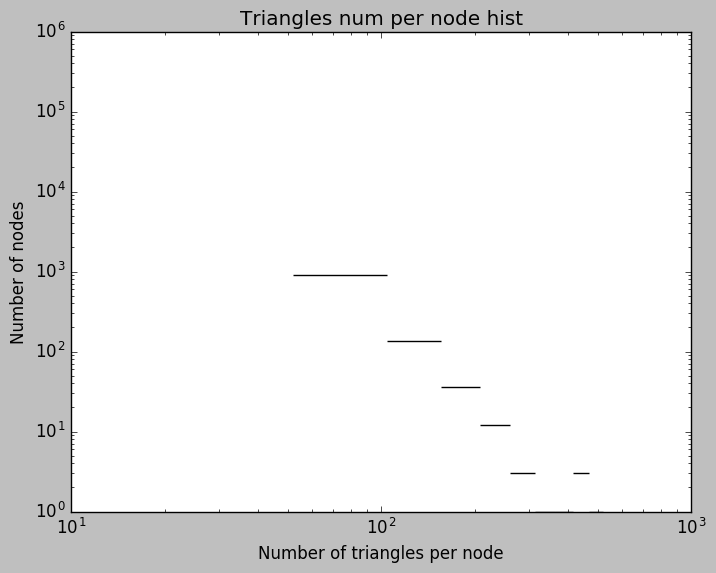

In [151]:
with plt.style.context(('classic')):
    plt.hist(tc_out['triangle_count'])
    plt.title("Triangles num per node hist")
    plt.xlabel("Number of triangles per node")
    plt.ylabel("Number of nodes")
    plt.loglog()
    plt.show()

### #5 Выводы

* У большинства вершин мало связей: до 100 штук.
* Плотность графа весьма мала, что подтверждает, что связей в нем не очень много.
* Всего ~1000 нодов состоит в ~100 треугольниках. Медиана -- 8 треугольников.

### #6 Визуализация


In [104]:
random_vertices = list(np.random.random_integers(min(g.vertices['__id']), max(g.vertices['__id']),40))
subgraph = g.get_neighborhood(random_vertices)
subgraph

/home/fogside/virtualenv/python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 262110 + 1) instead
  if __name__ == '__main__':


SGraph({'num_edges': 728, 'num_vertices': 322})
Vertex Fields:['__id']
Edge Fields:['__src_id', '__dst_id']

In [105]:
subgraph.show(node_size=100)

Как и показывает параметр плотности, граф довольно разреженный.

Потому случайно выбранные 40 нодов оказались несвязанными между собой.

*Попытка сделать что-то крутое используя deepWalk*
see: https://github.com/phanein/deepwalk

Загружаемая табличка доступна на dropbox по ссылке: https://www.dropbox.com/s/5ec40rrv4eo7pl7/deepWalkRepr.csv?dl=0

Она была получена так:

>**deepwalk --format edgelist --input the_graph_2.csv --output deepWalkRepr.csv --vertex-freq-degree --workers 3**

где **the_graph_2.csv** -- просто тот же файл с графом с пробелами вместо запятых и без названия.

In [28]:
from sklearn.decomposition import PCA

In [26]:
deepwalk_dict = {}
with open('./deepWalkRepr.csv', 'r') as deepWalk:
    data = deepWalk.readlines()
    data = [line.strip().split(' ') for line in data[1:]]
    for line in data:
        deepwalk_dict[int(line[0])] = [float(i) for i in line[1:]]

In [20]:
len(deepwalk_dict)

262111

In [26]:
data_dw = np.array(deepwalk_dict.values())

In [54]:
data_dw.shape

(262111, 64)

In [33]:
## Попробуем кластеризовать и посмотреть что получится...

from sklearn.cluster import MeanShift, estimate_bandwidth
# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(data_dw, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(data_dw)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 1


Кажется ничего совсем не вышло.. Один кластер. Ниже визуализация результатов PCA дает тот же результат.

Но все же deepWalk не совсем для этого)

In [30]:
#try to visualize this
pca2 = PCA(n_components=2)
pca2_deep_walk = pca2.fit_transform(data_dw)

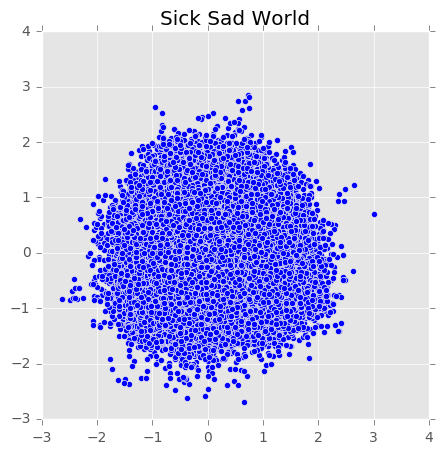

In [32]:
plt.figure(figsize=(5,5))
plt.scatter(pca2_deep_walk[:,0], pca2_deep_walk[:,1])
plt.title("Sick Sad World")
plt.show()

----
### 2. Генерация дополнительных данных - 20 Баллов

Перед нами стоит задача создания модели классификации, которая в дальнейшем будет использоваться для повышения разнообразия блока рекомендаций. Для большинства моделей классификации требуется минимум 2 класса объектов - негативный и позитивный. Но у нас есть только граф, ребра которые в нем присутствуют это позитивные примеры. Получается, что у нас нет негативных примеров. 

Ответьте на 3 вопроса:

1. Можем ли мы сами создать негативные примеры? Граф это описание связей между вершинами, если мы будем случайным образом выбирать две вершины и считать, что это ребро - негативный пример, имеет ли это смысл?
2. Если мы решим сгенерировать негативные примеры, как должна быть устроена процедура генерации, чтобы обобщаяющая способность модели была наилучшей?
3. Как зависит обобщающая способность модели от негативных примеров, которые мы ей покажем?

#### Ответы:
- 1) Да, это имеет смысл, если мы знаем, что между этими двумя вершинами нет ребра. 
- 2) Можно попробовать первоначально делать некую кластеризацию вершин и выбирать для негативных примеров те, которые не лежат в одном кластере.
- 3) Я думаю, что обучающая способность тем выше, чем шире разнообразие негативных примеров.

------
Создадим класс отрицательных примеров, сгенерировав его самым простым образом: берем две вершины, если ребро между ними отсутствует в графе, то это отрицательный пример.

1. Попробуйте улучшить генерацию отрицательных примеров

In [8]:
# read in existing edges
graph_file = open('the_graph.csv')
graph_file.readline() # first line is column names
existing_edges = set()

for x in graph_file:
    start, end = x.split(',')
    start, end = int(start), int(end)
    existing_edges.add((start, end))
    
print len(existing_edges)

1384871


In [9]:
# generating negative examples, so that class balance is 50/50 
generated_nonexisting_edges = []
counter = 0
while True:
    start = np.random.randint(0, vert_edgs['num_vertices'])
    end = np.random.randint(0, vert_edgs['num_vertices'])
    
    if (start != end) & ((start, end) not in existing_edges):
        generated_nonexisting_edges.append([start, end, 0])
        
    counter += 1
    if counter == vert_edgs['num_edges']:
        break

print len(generated_nonexisting_edges)

1384835


In [10]:
# create SFrame with negative examples
generated_nonexisting_edges = pd.DataFrame(data=generated_nonexisting_edges, columns=['src', 'dst', 'class'])
generated_nonexisting_edges = gl.SFrame(data=generated_nonexisting_edges)

In [11]:
# add target function to the original dataset 
edges['class'] = [1]*edges.shape[0]

In [12]:
# add negative examples to the main data and shuffle
edges = edges.append(generated_nonexisting_edges)
edges = gl.cross_validation.shuffle(edges)

In [13]:
# update our graph g with fake edges
g = gl.SGraph().add_edges(edges, src_field='src', dst_field='dst')

In [14]:
vert_edgs = g.summary()

print 'Number of vertices = {0}'.format(vert_edgs['num_vertices'])
print 'Number of edges = {0}'.format(vert_edgs['num_edges'])

Number of vertices = 262111
Number of edges = 2769706


----
### 3. Создание матрицы признаков для ребер - 30 Баллов

Для создания модели классификации нам необходимы признаки, которые описывают каждое ребро. Вот базовый список того, что можно посчитать:

Для вершин:

1. Список и количество вершин, из которых ребра приходят в данную вершину
2. Список и количество вершин, в которые ребра приходят из данной вершины
3. Список и количество вершин связанных с данной вершиной
4. Список и количество вершин, которые связанны с данной вершиной как входящими, так и исходящими ребрами

Также можно добавить: вершины с которыми данная вершина образует треугольники, кластеризовать вершины и использовать кластер данной вершины и др.

Придумайте дополнительные интересные признаки для вершин и вы получите дополнительный балл за домашнюю работу!

In [15]:
all_vertices = g.get_vertices()
all_vertices.rename({"__id": "id"}) 
all_vertices.head(3)

id
5
7
8


In [16]:
edges

src,dst,class
63447,157521,1
100040,819,1
6718,4441,1
74173,74176,1
212678,44000,0
63436,224784,1
153771,251324,0
160183,161312,1
61575,50631,1
156311,159768,1


In [17]:
# calculating each vertices in and out connections
out_vertices = edges.groupby("src", {"out_vertices": gl.aggregate.CONCAT("dst")})
out_vertices.rename({"src": "id"})

in_vertices = edges.groupby("dst", {"in_vertices": gl.aggregate.CONCAT("src")})
in_vertices.rename({"dst": "id"})
print out_vertices
print in_vertices

+--------+-------------------------------+
|   id   |          out_vertices         |
+--------+-------------------------------+
| 211023 | [230773, 57470, 76015, 189... |
| 79732  | [98701, 29666, 76251, 7973... |
|  7899  | [195606, 11624, 8189, 1207... |
| 25263  | [210716, 249660, 245641, 4... |
| 87629  | [137137, 248309, 1925, 137... |
| 43116  | [219273, 198797, 43113, 77... |
| 144280 | [22436, 25249, 173342, 152... |
| 238256 | [137206, 232329, 144346, 3... |
| 62361  | [70919, 128106, 62359, 115... |
|  5288  | [98895, 153587, 205141, 22... |
+--------+-------------------------------+
[262096 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.
+--------+-------------------------------+
|   id   |          in_vertices          |
+--------+-------------------------------+
| 211023 | [230499, 181303, 13670, 23... |
| 79732  | [261857, 26725, 103248, 79... |
|  7899  | [15258, 140017, 89

In [18]:
# join in and out connections with all_vertices
all_vertices = all_vertices.join(out_vertices, on="id", how="outer")
all_vertices = all_vertices.join(in_vertices, on="id", how="outer")

# replace missing values with empty lists
all_vertices = all_vertices.fillna('in_vertices',[])
all_vertices = all_vertices.fillna('out_vertices',[])
all_vertices.head(3)

id,out_vertices,in_vertices
211023,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ..."
79732,"[98701, 29666, 76251,79734, 81407, 75040, ...","[261857, 26725, 103248,79734, 83186, 187628, ..."
7899,"[195606, 11624, 8189,120719, 27312, 8977, ...","[15258, 140017, 8977,6150, 7896, 27312, 84 ..."


In [19]:
and_fun = lambda x: list(set(x[0])&set(x[1]))

In [20]:
or_fun = lambda x: list(set(x[0])|set(x[1]))

In [21]:
intersection = map(and_fun, zip(all_vertices["out_vertices"], all_vertices["in_vertices"]))
unit = map(or_fun, zip(all_vertices["out_vertices"], all_vertices["in_vertices"]))

In [22]:
all_vertices.add_column(gl.SArray(intersection, dtype=list),'in&out')
all_vertices.add_column(gl.SArray(unit, dtype=list),'in|out')

id,out_vertices,in_vertices,in&out
211023,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
79732,"[98701, 29666, 76251,79734, 81407, 75040, ...","[261857, 26725, 103248,79734, 83186, 187628, ...","[75040, 83186, 79730,79734, 81407] ..."
7899,"[195606, 11624, 8189,120719, 27312, 8977, ...","[15258, 140017, 8977,6150, 7896, 27312, 84 ...","[27312, 8977, 7896]"
25263,"[210716, 249660, 245641,42350, 6961, 42349, ...","[195903, 159040, 64227,206883, 179474, 6965, ...","[42349, 6965]"
87629,"[137137, 248309, 1925,137136, 256164, 160304, ...","[137136, 76237, 183943,211256, 105937, 127102, ...","[137136, 105937, 117244,127102, 137137] ..."
43116,"[219273, 198797, 43113,77990, 50535, 136497, ...","[28551, 146927, 37273,246688, 130121, 43114, ...","[50536, 43113, 43114,50535] ..."
144280,"[22436, 25249, 173342,152259, 207837, 169788, ...","[147749, 41283, 152259,84461, 79440, 152258, ...","[152258, 152259, 124943]"
238256,"[137206, 232329, 144346,30118, 175756, 233160, ...","[174226, 148063, 172161,249606, 216137, 232100, ...","[233160, 232100, 249606]"
62361,"[70919, 128106, 62359,115288, 37700, 64078, ...","[38016, 95810, 88073,189642, 62359, 70919, ...","[62359, 70917, 70918,70919] ..."
5288,"[98895, 153587, 205141,228550, 9421, 143593, ...","[5291, 38802, 9420, 7375,1642, 155442, 9421, 8 ...","[5468, 9421, 7373]"


Мы получили базовый набор данных - список входящих и исходящих вершин, для каждой вершины. Теперь найдем количества вершин для метрик 1 и 2. Метрики 3 и 4 вы посчитаете сами

In [23]:
# in_degree - number of users following each vertex
all_vertices['in_degree'] = all_vertices["in_vertices"].apply(lambda x: len(x) )

# out_degree - number of users each vertex is following
all_vertices['out_degree'] = all_vertices["out_vertices"].apply(lambda x: len(x) )

all_vertices['out&in_degree'] = all_vertices["in&out"].apply(lambda x: len(x) )

all_vertices['out|in_degree'] = all_vertices["in|out"].apply(lambda x: len(x) )

In [24]:
all_vertices.head(3)

Columns:
	id	int
	out_vertices	list
	in_vertices	list
	in&out	list
	in|out	list
	in_degree	int
	out_degree	int
	out&in_degree	int
	out|in_degree	int

Rows: 3

Data:
+--------+-------------------------------+-------------------------------+
|   id   |          out_vertices         |          in_vertices          |
+--------+-------------------------------+-------------------------------+
| 211023 | [230773, 57470, 76015, 189... | [230499, 181303, 13670, 23... |
| 79732  | [98701, 29666, 76251, 7973... | [261857, 26725, 103248, 79... |
|  7899  | [195606, 11624, 8189, 1207... | [15258, 140017, 8977, 6150... |
+--------+-------------------------------+-------------------------------+
+-------------------------------+-------------------------------+-----------+------------+
|             in&out            |             in|out            | in_degree | out_degree |
+-------------------------------+-------------------------------+-----------+------------+
|        [233626, 198886]       | [57538, 13670, 161931, 248... |     13    |     16     |
| [75040, 83186, 79730, 7973... | [81408, 49025, 137159, 987... |     19    |     12     |
|      [27312, 8977, 7896]      | [254022, 76686, 120719, 89... |     13    |     11     |
+-------------------------------+-------------------------------+-----------+------------+
+---------------+---------------+
| out&in_degree | out|in_degree |
+---------------+---------------+
|       2       |       27      |
|       5       |       26      |
|       3       |       21      |
+---------------+---------------+
[3 rows x 9 columns]

In [27]:
##### try to add deepWalk features ###
for i in range(64):
    all_vertices['deepWalk_{}'.format(i)] = [deepwalk_dict[id_][i] for id_ in all_vertices['id']]

In [28]:
all_vertices.shape

(262111, 73)

Мы получили характеристики для каждой вершины графа. Так как у нас задача предсказания наличия ребра, мы должны составить описание каждого ребра, используя метрики вершин. После составления характеристик ребер, мы можем перейти к генерации свойств ребер, взяв за основу метрики вершин ребра. Пример метрик для ребер, которые мы можем найти:

1. Общие друзья вершин ребра
2. Общее количество друзей вершин ребра
3. Коэффициенты Жаккара, Пирсона, Адамик - Адара, косинусная мера

Данные метрики находятся для каждого списка вершин, пунктов 1 - 4

In [29]:
edges

src,dst,class
63447,157521,1
100040,819,1
6718,4441,1
74173,74176,1
212678,44000,0
63436,224784,1
153771,251324,0
160183,161312,1
61575,50631,1
156311,159768,1


In [30]:
edges = edges.join(all_vertices, on={"src": "id"}, how="right")

# edges.rename({"in_vertices": "src_in_vertices", "out_vertices": "src_out_vertices",
#                   "in_degree": "src_in_degree", "out_degree": "src_out_degree", "in&out":"src_in&out",
#              "in|out":"src_in|out", "out&in_degree":"src_out&in_degree", "out|in_degree": "src_out|in_degree"})

edges.rename({name_old: 'src_'+name_old for name_old in all_vertices.column_names() if name_old!='id'})

edges = edges.join(all_vertices, on={"dst": "id"}, how="right")

# edges.rename({"in_vertices": "dst_in_vertices", "out_vertices": "dst_out_vertices",
#                   "in_degree": "dst_in_degree", "out_degree": "dst_out_degree", "in&out":"dst_in&out",
#              "in|out":"dst_in|out", "out&in_degree":"dst_out&in_degree", "out|in_degree": "dst_out|in_degree"})
edges.rename({name_old: 'dst_'+name_old for name_old in all_vertices.column_names() if name_old!='id'})


edges.head(1)

Columns:
	src	int
	dst	int
	class	int
	src_out_vertices	list
	src_in_vertices	list
	src_in&out	list
	src_in|out	list
	src_in_degree	int
	src_out_degree	int
	src_out&in_degree	int
	src_out|in_degree	int
	src_deepWalk_0	float
	src_deepWalk_1	float
	src_deepWalk_2	float
	src_deepWalk_3	float
	src_deepWalk_4	float
	src_deepWalk_5	float
	src_deepWalk_6	float
	src_deepWalk_7	float
	src_deepWalk_8	float
	src_deepWalk_9	float
	src_deepWalk_10	float
	src_deepWalk_11	float
	src_deepWalk_12	float
	src_deepWalk_13	float
	src_deepWalk_14	float
	src_deepWalk_15	float
	src_deepWalk_16	float
	src_deepWalk_17	float
	src_deepWalk_18	float
	src_deepWalk_19	float
	src_deepWalk_20	float
	src_deepWalk_21	float
	src_deepWalk_22	float
	src_deepWalk_23	float
	src_deepWalk_24	float
	src_deepWalk_25	float
	src_deepWalk_26	float
	src_deepWalk_27	float
	src_deepWalk_28	float
	src_deepWalk_29	float
	src_deepWalk_30	float
	src_deepWalk_31	float
	src_deepWalk_32	float
	src_deepWalk_33	float
	src_deepWalk_34	float
	src_deepWalk_35	float
	src_deepWalk_36	float
	src_deepWalk_37	float
	src_deepWalk_38	float
	src_deepWalk_39	float
	src_deepWalk_40	float
	src_deepWalk_41	float
	src_deepWalk_42	float
	src_deepWalk_43	float
	src_deepWalk_44	float
	src_deepWalk_45	float
	src_deepWalk_46	float
	src_deepWalk_47	float
	src_deepWalk_48	float
	src_deepWalk_49	float
	src_deepWalk_50	float
	src_deepWalk_51	float
	src_deepWalk_52	float
	src_deepWalk_53	float
	src_deepWalk_54	float
	src_deepWalk_55	float
	src_deepWalk_56	float
	src_deepWalk_57	float
	src_deepWalk_58	float
	src_deepWalk_59	float
	src_deepWalk_60	float
	src_deepWalk_61	float
	src_deepWalk_62	float
	src_deepWalk_63	float
	dst_out_vertices	list
	dst_in_vertices	list
	dst_in&out	list
	dst_in|out	list
	dst_in_degree	int
	dst_out_degree	int
	dst_out&in_degree	int
	dst_out|in_degree	int
	dst_deepWalk_0	float
	dst_deepWalk_1	float
	dst_deepWalk_2	float
	dst_deepWalk_3	float
	dst_deepWalk_4	float
	dst_deepWalk_5	float
	dst_deepWalk_6	float
	dst_deepWalk_7	float
	dst_deepWalk_8	float
	dst_deepWalk_9	float
	dst_deepWalk_10	float
	dst_deepWalk_11	float
	dst_deepWalk_12	float
	dst_deepWalk_13	float
	dst_deepWalk_14	float
	dst_deepWalk_15	float
	dst_deepWalk_16	float
	dst_deepWalk_17	float
	dst_deepWalk_18	float
	dst_deepWalk_19	float
	dst_deepWalk_20	float
	dst_deepWalk_21	float
	dst_deepWalk_22	float
	dst_deepWalk_23	float
	dst_deepWalk_24	float
	dst_deepWalk_25	float
	dst_deepWalk_26	float
	dst_deepWalk_27	float
	dst_deepWalk_28	float
	dst_deepWalk_29	float
	dst_deepWalk_30	float
	dst_deepWalk_31	float
	dst_deepWalk_32	float
	dst_deepWalk_33	float
	dst_deepWalk_34	float
	dst_deepWalk_35	float
	dst_deepWalk_36	float
	dst_deepWalk_37	float
	dst_deepWalk_38	float
	dst_deepWalk_39	float
	dst_deepWalk_40	float
	dst_deepWalk_41	float
	dst_deepWalk_42	float
	dst_deepWalk_43	float
	dst_deepWalk_44	float
	dst_deepWalk_45	float
	dst_deepWalk_46	float
	dst_deepWalk_47	float
	dst_deepWalk_48	float
	dst_deepWalk_49	float
	dst_deepWalk_50	float
	dst_deepWalk_51	float
	dst_deepWalk_52	float
	dst_deepWalk_53	float
	dst_deepWalk_54	float
	dst_deepWalk_55	float
	dst_deepWalk_56	float
	dst_deepWalk_57	float
	dst_deepWalk_58	float
	dst_deepWalk_59	float
	dst_deepWalk_60	float
	dst_deepWalk_61	float
	dst_deepWalk_62	float
	dst_deepWalk_63	float

Rows: 1

Data:
+--------+--------+-------+-------------------------------+
|  src   |  dst   | class |        src_out_vertices       |
+--------+--------+-------+-------------------------------+
| 211023 | 159269 |   1   | [230773, 57470, 76015, 189... |
+--------+--------+-------+-------------------------------+
+-------------------------------+------------------+
|        src_in_vertices        |    src_in&out    |
+-------------------------------+------------------+
| [230499, 181303, 13670, 23... | [233626, 198886] |
+-------------------------------+------------------+
+-------------------------------+---------------+----------------+-------------------+
|           src_in|out          | src_in_d

Найдем пункт 1 - общих друзей для списков вершин из пункта 1. Пункты 2 и 3 вы посчитаете самостоятельно,

* Общие друзья вершин ребра
* Общее количество друзей вершин ребра
* Коэффициенты Жаккара, Пирсона, Адамик - Адара, косинусная мера

In [31]:
def common_friends(u, v, u_neighbors, v_neighbors):
    u_neighbors = set(u_neighbors)
    if v in u_neighbors:
            u_neighbors.remove(v)

    v_neighbors = set(v_neighbors)
    if u in v_neighbors:
        v_neighbors.remove(u)
        
    return len(u_neighbors & v_neighbors)

In [32]:
def common_friends_lst(u, v, u_neighbors, v_neighbors):
    u_neighbors = set(u_neighbors)
    if v in u_neighbors:
            u_neighbors.remove(v)

    v_neighbors = set(v_neighbors)
    if u in v_neighbors:
        v_neighbors.remove(u)
        
    return list(u_neighbors & v_neighbors)

In [33]:
def Jaccar(u, v, u_in, u_out, v_in, v_out):
    common = set(u_in)|set(u_out)|set(v_in)|set(v_out)
    diff = (set(u_in)|set(u_out))&(set(v_in)|set(v_out))
    return len(diff)*1./(len(common)-len(diff))

In [34]:
deg_graph.vertices[:3]

__id,in_degree,out_degree,total_degree
5,54,5,59
7,34,6,40
8,295,5,300


In [35]:
neighboors_dict = {i:deg_graph.vertices['__id' == i]['total_degree'] for i in g.vertices['__id']}

In [36]:
def Adamic_Adar(common_lst_in, common_lst_out):
    
    common_friends = list(set(common_lst_in)|set(common_lst_out))
    if common_friends == []:
        return 0
    
    result = 0
    for f in common_friends:
        ffriends = neighboors_dict[int(f)]-2
        result+=1./np.log(ffriends)
    return result

In [45]:
def deep_walk_product(x_id,y_id):
    return np.array(deepwalk_dict[x_id]).dot(np.array(deepwalk_dict[y_id]))

In [37]:
edges['common_in_vertices'] = (edges[['src','dst', 'src_in_vertices', 'dst_in_vertices']]
                               .apply(lambda x: common_friends(x['src'], x['dst'],x['src_in_vertices'], x['dst_in_vertices'])))

In [38]:
edges['common_out_vertices'] = (edges[['src','dst', 'src_out_vertices', 'dst_out_vertices']]
                               .apply(lambda x: common_friends(x['src'], x['dst'],x['src_out_vertices'], x['dst_out_vertices'])))

In [41]:
edges['common_in_vertices_lst'] = (edges[['src','dst', 'src_in_vertices', 'dst_in_vertices']]
                              .apply(lambda x: common_friends_lst(x['src'], x['dst'],x['src_in_vertices'], x['dst_in_vertices']))).astype(list)

In [42]:
edges['common_out_vertices_lst'] = (edges[['src','dst', 'src_out_vertices', 'dst_out_vertices']]
                              .apply(lambda x: common_friends_lst(x['src'], x['dst'],x['src_out_vertices'], x['dst_out_vertices']))).astype(list)

In [39]:
edges['Jaccar'] = (edges[['src','dst', 'src_out_vertices', 'src_in_vertices','dst_in_vertices', 'dst_out_vertices']]
                               .apply(lambda x: Jaccar(x['src'], x['dst'],
                                                                   x['src_out_vertices'], x['src_in_vertices'],
                                                                   x['dst_out_vertices'], x['dst_out_vertices'])))

In [43]:
ad_adar = (edges[["common_in_vertices_lst", "common_out_vertices_lst"]]
                              .apply(lambda x: Adamic_Adar(x["common_in_vertices_lst"], x["common_out_vertices_lst"])))

In [47]:
dw_product = (edges[["src", "dst"]]
                              .apply(lambda x: deep_walk_product(x["src"], x["dst"])))

In [48]:
edges.add_column(dw_product, name='dw_product')

src,dst,class,src_out_vertices,src_in_vertices,src_in&out
211023,159269,1,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,189714,1,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,244758,0,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,57470,0,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,233626,1,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,252560,0,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,230773,0,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,198886,1,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,224381,1,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,143972,0,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"


In [44]:
edges.add_column(ad_adar, name='Adamic_Adar')

src,dst,class,src_out_vertices,src_in_vertices,src_in&out
211023,159269,1,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,189714,1,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,244758,0,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,57470,0,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,233626,1,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,252560,0,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,230773,0,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,198886,1,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,224381,1,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,143972,0,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"


Результатом пункта 3 является матрица признаков. Теперь мы готовы занятся настройкой моделей. Главная ваша задача в пункте 3 - подготовить как можно больше качественных признаков, которые могли бы использоваться для настройки модели машинного обучения.

----
### 4. Настройка модели и валидация качества модели - 20 Баллов

Исключим подозрительные ребра из рассмотрения, а затем разобьем датасет на 2 части, для обучения и проверки результатов. Настроим базовую модель классификации - логистическую регрессию.
Для улучшения качества модели вам предстоит выполнить следующие пункты:

1. Кросс - валидация для настройки гиперпараметров модели и регуляризации
2. Подбор модели машинного обучения (случайный лес, бустинг, нейронная сеть и т.д.)

In [49]:
print edges.shape

(2769706, 154)


In [50]:
susp = gl.SFrame.read_csv('suspicions.csv', delimiter=',', verbose=False)
print susp.shape

(299994, 3)


In [51]:
print edges.shape
edges = edges.join(susp, on=['src', 'dst'], how='left')
print edges.shape

(2769706, 154)
(2769706, 155)


In [52]:
clean_edges = edges[edges['edge_id'] == None]
susp_edges = edges[edges['edge_id'] != None]
print clean_edges.shape, susp_edges.shape

(2469712, 155) (299994, 155)


In [53]:
clean_edges.remove_column('edge_id')

src,dst,class,src_out_vertices,src_in_vertices,src_in&out
211023,189714,1,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,244758,0,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,57470,0,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,233626,1,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,252560,0,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,230773,0,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,198886,1,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,143972,0,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,246520,0,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"
211023,76015,0,"[230773, 57470, 76015,189713, 233626, 252560, ...","[230499, 181303, 13670,236267, 233626, 248527, ...","[233626, 198886]"


In [54]:
## костыль.
clean_edges['common_in_vertices_lst'] = gl.SArray([[int(i) for i in g] if g!=[] 
                                                   else [] for g in clean_edges['common_in_vertices_lst']], dtype=list)

In [55]:
clean_edges['common_out_vertices_lst'] = gl.SArray([[int(i) for i in g] if g!=[] 
                                                   else [] for g in clean_edges['common_out_vertices_lst']], dtype=list)

In [82]:
# split on train and test
test, train = clean_edges.random_split(0.2)

In [83]:
print test.shape, train.shape

(494650, 154) (1975062, 154)


In [79]:
chosen_feat = ["src_out&in_degree", "dst_out|in_degree", "Jaccar",
               "Adamic_Adar", "dst_in_degree", "src_out_degree", "src",
               "dst", "src_out|in_degree", "dw_product", "common_in_vertices"]
len(chosen_feat)

11

In [ ]:
## Эта модель дала на public_leaderboard 0.95, что для меня было весьма печально..
## Фичи были выбраны на основе прошлых экспериментов и feature_importance

In [80]:
model_product_all = gl.classifier.boosted_trees_classifier.create(train, 
                                                 target="class", 
                                                 features=chosen_feat,
                                                 max_iterations = 5, metric = 'auc', column_subsample=0.7,random_seed=23,
                                                     min_loss_reduction = 0.04, early_stopping_rounds=3)
results4 = model_product_all.evaluate(test)
print results4

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 1877516

Number of classes           : 2

Number of feature columns   : 11

Number of unpacked features : 11

+-----------+--------------+--------------+----------------+

| Iteration | Elapsed Time | Training-auc | Validation-auc |

+-----------+--------------+--------------+----------------+

| 1         | 0.879528     | 0.998571     | 0.998546       |

| 2         | 1.758515     | 0.998954     | 0.998926       |

| 3         | 2.495218     | 0.999065     | 0.999051       |

| 4         | 3.272294     | 0.999135     | 0.999123       |

| 5         | 4.076956     | 0.999158     | 0.999151       |

+-----------+--------------+--------------+----------------+

{'f1_score': 0.9841931963225365, 'auc': 0.9991660130107964, 'recall': 0.9817279349014434, 'precision': 0.9866708701719573, 'log_loss': 0.14161584340188815, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+-----+-----+--------+--------+
| threshold | fpr | tpr |   p    |   n    |
+-----------+-----+-----+--------+--------+
|    0.0    | 1.0 | 1.0 | 216779 | 276951 |
|   1e-05   | 1.0 | 1.0 | 216779 | 276951 |
|   2e-05   | 1.0 | 1.0 | 216779 | 276951 |
|   3e-05   | 1.0 | 1.0 | 216779 | 276951 |
|   4e-05   | 1.0 | 1.0 | 216779 | 276951 |
|   5e-05   | 1.0 | 1.0 | 216779 | 276951 |
|   6e-05   | 1.0 | 1.0 | 216779 | 276951 |
|   7e-05   | 1.0 | 1.0 | 216779 | 276951 |
|   8e-05   | 1.0 | 1.0 | 216779 | 276951 |
|   9e-05   | 1.0 | 1.0 | 216779 | 276951 |
+-----------+-----+-----+--------+--------+
[100001 rows x 5 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print m

In [81]:
model_product_all.get_feature_importance()

name,index,count
dw_product,None,68
dst,None,43
dst_in_degree,None,36
src_out&in_degree,None,28
Adamic_Adar,None,21
src,None,18
src_out|in_degree,None,13
dst_out|in_degree,None,5
Jaccar,None,3
src_out_degree,None,0


In [ ]:
## Эта модель заработала скор 0.97 на public leaderboard
## Использованные в ней фичи -- основные + deep_walk векторы как они есть, без их product'а
## Я слишком поздно заметила, что случайно скопировала векторы deep_walk несколько раз 

In [156]:
all_feat = [x for x in train.column_names() if 'class' not in x]

In [120]:
model = gl.classifier.boosted_trees_classifier.create(train, 
                                                 target="class", 
                                                 features=all_feat,
                                                 max_iterations = 10, metric = 'auc', column_subsample=0.7,random_seed=23,
                                                     min_loss_reduction = 0.04, early_stopping_rounds=5)
results2 = model.evaluate(test)
print results2

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 1877372

Number of classes           : 2

Number of feature columns   : 330

Number of unpacked features : 330

+-----------+--------------+--------------+----------------+

| Iteration | Elapsed Time | Training-auc | Validation-auc |

+-----------+--------------+--------------+----------------+

| 1         | 48.858071    | 0.954372     | 0.954818       |

| 2         | 96.813697    | 0.958660     | 0.958542       |

| 3         | 144.408705   | 0.962807     | 0.962743       |

| 4         | 204.357538   | 0.964059     | 0.964018       |

| 5         | 251.736836   | 0.966056     | 0.965974       |

| 6         | 299.396571   | 0.966581     | 0.966535       |

| 7         | 347.491148   | 0.968513     | 0.968414       |

| 8         | 407.168984   | 0.969071     | 0.968879       |

| 9         | 454.833228   | 0.969417     | 0.969146       |

| 10        | 502.980739   | 0.974226     | 0.974039       |

+-----------+--------------+--------------+----------------+

{'f1_score': 0.9211505722645167, 'auc': 0.9738530802982502, 'recall': 0.8653020722758111, 'precision': 0.9847056413703997, 'log_loss': 0.20363188750900796, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+-----+-----+--------+--------+
| threshold | fpr | tpr |   p    |   n    |
+-----------+-----+-----+--------+--------+
|    0.0    | 1.0 | 1.0 | 216670 | 276621 |
|   1e-05   | 1.0 | 1.0 | 216670 | 276621 |
|   2e-05   | 1.0 | 1.0 | 216670 | 276621 |
|   3e-05   | 1.0 | 1.0 | 216670 | 276621 |
|   4e-05   | 1.0 | 1.0 | 216670 | 276621 |
|   5e-05   | 1.0 | 1.0 | 216670 | 276621 |
|   6e-05   | 1.0 | 1.0 | 216670 | 276621 |
|   7e-05   | 1.0 | 1.0 | 216670 | 276621 |
|   8e-05   | 1.0 | 1.0 | 216670 | 276621 |
|   9e-05   | 1.0 | 1.0 | 216670 | 276621 |
+-----------+-----+-----+--------+--------+
[100001 rows x 5 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print m

In [116]:
model.get_feature_importance()

name,index,count
src_out&in_degree,None,50
dst_in_degree,None,43
src_out_degree,None,42
dst_out|in_degree,None,41
src,None,36
dst_out&in_degree,None,30
src_out|in_degree,None,29
dst,None,29
Jaccar,None,26
Adamic_Adar,None,18


Мы получили базовую модель с метриками: точность ~ 0.67, ROC AUC ~ 0.71. Ваша задача улучшить модель,  за счет добавления новых признаков вершин, ребер и аккуратного обучения выбранных моделей (настройки гиперпараметров и регуляризации).

----
### 5. Отправка результатов в контест на Kaggle - 20 Баллов


Завершая домашнюю работу, нам небходимо предсказать вероятности наличия ребер, для заданного списка ребер. Результат отправлется в контест на kaggle.com в формате: edge_id - probability

In [68]:
susp_edges['common_in_vertices_lst'] = gl.SArray([[int(i) for i in g] if g!=[] 
                                                   else [] for g in susp_edges['common_in_vertices_lst']], dtype=list)

In [69]:
susp_edges['common_out_vertices_lst'] = gl.SArray([[int(i) for i in g] if g!=[] 
                                                   else [] for g in susp_edges['common_out_vertices_lst']], dtype=list)

In [86]:
predicted = model_product_all.predict(susp_edges[chosen_feat], output_type='probability')

In [87]:
susp_edges['probability'] = predicted

In [88]:
result = susp_edges['edge_id', 'probability']

In [89]:
result.save('result_deep_walk_product_1.csv', format='csv')

----
### Не модифицируйте данный код, он для проверки вашего ноутбука

In [35]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# %matplotlib inline

In [36]:
# labeled = pd.read_csv('labeled_suspicions.csv')
# print labeled.shape

# res = labeled.merge(result.to_dataframe(), on='edge_id', how='inner')
# res = res[['class', 'probability']]
# print res.shape

In [37]:
# fpr, tpr, _ = roc_curve(res['class'], res['probability'])
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(15, 10))
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()